# Imports and settings

In [1]:
# Imports and settings.
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from torch.autograd import Variable
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertModel
from transformers import get_linear_schedule_with_warmup
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

     |████████████████████████████████| 890kB 9.4MB/s 
     |████████████████████████████████| 890kB 42.8MB/s 
     |████████████████████████████████| 3.0MB 50.5MB/s 
     |████████████████████████████████| 1.1MB 53.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cc2d6f8099d541ed446a9c1181525b826221488b96d125d2efc7956f3e408542
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
#Download Tec, CF and Wang datasets
!git clone https://gitlab.com/Georgios.Hadjiharalambous/emotion-detection-in-short-texts-datasets
!cp './emotion-detection-in-short-texts-datasets/CrowdFlower.csv' 'CrowdFlower.csv'
!cp './emotion-detection-in-short-texts-datasets/Wang.csv' 'Wang.csv'
!cp './emotion-detection-in-short-texts-datasets/TEC.csv' 'TEC.csv'

Cloning into 'emotion-detection-in-short-texts-datasets'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


# Model definition


In [3]:
#This class is the implementation of Bert classifier i.e simple Bert with an extra classification layer on top.
#We use the Bert model implementation as provided by the huggingface library
#Link can be fount at https://huggingface.co/transformers/_modules/transformers/modeling_bert.html

class BertClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_prob=0.5, bert_hidden_size=768):


        # Initializes the BertClassifier model object.
      
        # Parameters:
        #     model_name: {String} exact name of the Bert model to be used during training. (Usually "bert-base-uncased")
        #     num_labels: {int} Number of labels.
        #     dropout_prob : {float} The dropout probability for the classification layer.
        #     bert_hidden_size: {int} Bert hidden dimension for its last-output layer. (Usually for "bert-base-uncased" is 768)
        
        super().__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.l1 = nn.Linear(bert_hidden_size,num_labels)


    def forward(self, input_ids = None, attention_mask = None):
        # Processes the input data to produce the classification output and the attention weight tensor.

        # Parameters:
        #     input_data: {torch.Tensor} Input data.
        #     attention_mask: {torch.Tensor} Indices to avoid performing attention to due to padded tokens

        outputs = self.bert(input_ids, attention_mask = attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        outputs = self.l1(pooled_output)
        outputs = torch.log_softmax(outputs,1) 
        return outputs  

# Evaluation Functions


In [4]:
def get_classes_stats(predicted_output, true_output):

    # Returns the calculated evaluation metrics for each class.
    
    # Parameters:
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.

    report_dict = classification_report(true_output, predicted_output, output_dict=True)
    classes = []
    classes_stats = []
    for key in report_dict:
        if key not in ["accuracy", "macro avg", "weighted avg"]:
          classes.append(int(float(key)))
          stats = [float("%0.3f" % (report_dict[key]['precision'])), float("%0.3f" % (report_dict[key]['recall'])), 
                    float("%0.3f" % (report_dict[key]['f1-score'])), report_dict[key]['support']]
          classes_stats.append(stats)
    return [classes, classes_stats]
def create_report(parameters, run_function, num_classes, num_iters):

    # Creates an overall evaluation report after training and testing a model on binary or multiclass classification for a set number of iterations.

    # Parameters:
    #     parameters: {list} List of parameters.
    #     run_function: {function} Function to train and test a model on binary or multiclass classification.
    #     num_classes: {int} Number of classes.
    #     num_iters: {int} Number of iterations.

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    classes = {}
    print("CREATING REPORT:")
    for i in range(num_iters):
        print("Run: " + str(i + 1))
        result = run_function(parameters[0], parameters[1], parameters[2], parameters[3], False)
        print("Accuracy: %0.3f" % result[0][0])
        print("Precision (WEIGHT_AVG): %0.3f" % result[0][1])
        print("Recall (WEIGHT_AVG): %0.3f" % result[0][2])
        print("F1 (WEIGHT_AVG): %0.3f" % result[0][3])
        accuracy_list.append(result[0][0])
        precision_list.append(result[0][1])
        recall_list.append(result[0][2])
        f1_list.append(result[0][3])
        for j in range(1, num_classes + 1, 1):
            print((str(result[j][0]) + " | Precision: %0.3f Recall: %0.3f F1: %0.3f") % (result[j][1], result[j][2], result[j][3]))
            if result[j][0] not in classes:
                classes[result[j][0]] = {}
            if "Precision_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Precision_List"] = []
            classes[result[j][0]]["Precision_List"].append(result[j][1])
            if "Recall_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Recall_List"] = []
            classes[result[j][0]]["Recall_List"].append(result[j][2])
            if "F1_List" not in classes[result[j][0]]:
                classes[result[j][0]]["F1_List"] = []
            classes[result[j][0]]["F1_List"].append(result[j][3])
    general_stats = [["%0.3f [%0.3f]" % (np.mean(np.asarray(accuracy_list)), np.std(np.asarray(accuracy_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(precision_list)), np.std(np.asarray(precision_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(recall_list)), np.std(np.asarray(recall_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(f1_list)), np.std(np.asarray(f1_list)))]]
    class_labels = []
    class_stats = []
    for key in classes:
        class_labels.append(key)
        precision = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Precision_List"])), np.std(np.asarray(classes[key]["Precision_List"])))
        recall = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Recall_List"])), np.std(np.asarray(classes[key]["Recall_List"])))
        f1 = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["F1_List"])), np.std(np.asarray(classes[key]["F1_List"])))
        class_stats.append([precision, recall, f1])
    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)  
    col_labels = ["Accuracy [STD]", "Precision (WEIGHT_AVG) [STD]", "Recall (WEIGHT_AVG) [STD]", "F1 (WEIGHT_AVG) [STD]"]
    table = ax.table(cellText=general_stats, rowLabels=[parameters[0]], colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')
    ax = fig.add_subplot(3, 1, 3)
    col_labels = ["Precision [STD]", "Recall [STD]", "F1 [STD]"]
    table = ax.table(cellText=class_stats, rowLabels=class_labels, colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')

def plot_confusion_matrix(description, predicted_output, true_output, labels_dict, normalize=False):

    # Plots a confusion matrix for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     normalize: {bool} Normalize values or not.

    title = "Confusion matrix: '%s'" % (description)
    if normalize:
        title = title + " (Normalized)"
    cm = confusion_matrix(true_output, predicted_output)
    classes = get_classes_stats(predicted_output, true_output)[0]
    labels = []
    for item in classes:
        labels.append(labels_dict[item])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), yticklabels=labels)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("True labels", fontsize=20)
    ax.set_xlabel("Predicted labels", fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)

# Dataset Loading and Processing Functions

In [14]:
def load_crowdflower_multiclass():

    # Loads the CrowdFlower dataset for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("CrowdFlower.csv", delimiter=",", dtype={"id": int, "emotion": str, "author": str, "text": str})
    dataframe = dataframe.drop(dataframe.columns[[0, 2]], axis=1)
    dataframe = dataframe[dataframe.emotion != "empty"]
    dataframe = dataframe[dataframe.emotion != "love"]
    dataframe = dataframe[dataframe.emotion != "fun"]
    dataframe = dataframe[dataframe.emotion != "relief"]
    dataframe = dataframe[dataframe.emotion != "enthusiasm"]
    dataframe = dataframe[dataframe.emotion != "boredom"]
    dataframe = dataframe[dataframe.emotion != "anger"]
    dataframe = dataframe[dataframe.emotion != "neutral"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("hate", 0).replace("worry", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 1310
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict
  
def load_tec_multiclass():

    # Loads the TEC dataset for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("TEC.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "disgust"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 1550
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train, 
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test, 
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_multiclass():

    # Loads the Wang dataset for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "love"]
    dataframe = dataframe[dataframe.emotion != "thankfulness"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_multiclass_6():

    # Loads the Wang dataset for multiclass (3Pos) classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love", 5: "Thankfulness"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4).replace("thankfulness", 5)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_thankfulness = dataframe[dataframe.emotion == 5][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_thankfulness_train = dataframe_thankfulness[:int(0.8 * min_size)]
    dataframe_thankfulness_test = dataframe_thankfulness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train, 
                                 dataframe_thankfulness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test, 
                                dataframe_thankfulness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_multiclass_5():

    # Loads the Wang dataset for multiclass (2Pos) classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "thankfulness"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict


def load_vent_multiclass_4():

    # Loads the VENT dataset for multiclass classification with the Bert model.

    labels_dict = {0: "anger", 1: "fear", 2: "sadness", 3: "happiness"}
    dataframe = pd.read_csv("cent4_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    #print(dataframe)
    dataframe.text.astype(str)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)
    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    #return 0


    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict



def load_vent_multiclass_5():

    # Loads the VENT dataset for multiclass (2Pos) classification with the Bert model.

    labels_dict = {0: "anger", 1: "fear", 2: "sadness", 3: "happiness",4:'love'}
    dataframe = pd.read_csv("cent5_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train,dataframe_love_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test,dataframe_love_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict


def load_vent_multiclass_6():

    # Loads the VENT dataset for multiclass (3Pos) classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love", 5: "Thankfulness"}
    dataframe = pd.read_csv("cent6_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4).replace("thankfulness", 5)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_thankfulness = dataframe[dataframe.emotion == 5][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_thankfulness_train = dataframe_thankfulness[:int(0.8 * min_size)]
    dataframe_thankfulness_test = dataframe_thankfulness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train,dataframe_love_train,dataframe_thankfulness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,dataframe_love_test,
                                dataframe_happiness_test, dataframe_thankfulness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

In [6]:
def tokenize_map_pad_mask(sentences,MAX_LEN = 35):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'                       
                  )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
    #pad the sentences   
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                        value=0, truncating="post", padding="post")
    

  # Create attention masks which provide the indices to avoid performing attention to due to padded tokens
  attention_masks = []
  for sent in input_ids:        
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]      
      attention_masks.append(att_mask)
  return input_ids,attention_masks        

# Training and testing functions

In [7]:
def train(model, train_dataloader, gradient_clipping, scheduler, optimizer, num_epochs=1,verbose=False):
  # Trains the BertClassifier model for multiclass classification 
    # Parameters:
    #     model: {BertClassifier} Bert classifier model to be trained.
    #     train_dataloader: {torch.utils.data.DataLoader} Data loader containing training data.
    #     gradient_clipping: {bool} Use gradient clipping or not.
    #     scheduler : Used for adapting learning rate.
    #     optimizer: {torch.optim.RMSprop} Optimizer to be used in training.
    #     num_epochs: {int} Number of epochs.
    #     verbose: {bool} Verbose or not.

  num_batches=0
  losses=[]
  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Store the average loss after each epoch so we can plot them.
  loss_values = []
  accuracies = []
  loss_fct = torch.nn.NLLLoss()

  for epoch_i in range(0, num_epochs):
      
      # Reset the total loss for this epoch.
      total_loss = 0

     
      model.train()

      for step, batch in enumerate(train_dataloader):       

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          input_ids = batch[0].to(device)
          input_mask = batch[1].to(device)
          labels = batch[2].to(device)

          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          
          logits = model(input_ids, attention_mask = input_mask)                   
          loss = loss_fct(logits, labels)          
          total_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
          
          optimizer.step()

          # Update the learning rate.
          scheduler.step()
          
          num_batches += 1    
      if verbose:
        print("Average loss: %0.3f" % (total_loss / num_batches))      
      losses.append(total_loss / num_batches)
  return losses, accuracies

In [8]:
def evaluate(model, test_output, prediction_dataloader,verbose=True):
  # Put model in evaluation mode
  model.eval()

  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    input_ids, input_mask, labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask = input_mask)

    logits = outputs
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  predictions_=[]
  for pred in predictions:
    predictions_.append(np.argmax(pred,axis=1))
  predicted_test_output=[]
  for batch in predictions_:
    predicted_test_output.extend(batch)
  test_output_var = test_output

  accuracy = accuracy_score(predicted_test_output,test_output_var)
  if verbose:
      print("Accuracy: %0.3f" % (accuracy))
  return accuracy, predicted_test_output

In [9]:
def evaluation_summary(description, predicted_output, true_output, labels_dict, verbose=True):

    # Returns an evaluation report for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     verbose: {bool} Verbose or not.

    precision = precision_score(true_output, predicted_output, average='weighted')
    recall = recall_score(true_output, predicted_output, average='weighted')
    accuracy = accuracy_score(true_output, predicted_output)
    f1 = fbeta_score(true_output, predicted_output, 1, average='weighted')
    classes = get_classes_stats(predicted_output, true_output)[0]
    classes_stats = get_classes_stats(predicted_output, true_output)[1]
    result = [[accuracy, precision, recall, f1]]
    
    if verbose:
        print("Classifier '%s':" % (description))
        print("Accuracy: %0.3f" % (accuracy))
        print("Precision (WEIGHT_AVG): %0.3f" % (precision))
        print("Recall (WEIGHT_AVG): %0.3f" % (recall))
        print("F1 (WEIGHT_AVG): %0.3f" % (f1))
    for i in range(len(classes)):
        if verbose:
            print((labels_dict[classes[i]] + " | Precision: %0.3f Recall: %0.3f F1: %0.3f Support: " + str(classes_stats[i][3])) % 
                  (classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]))
        result.append([labels_dict[classes[i]], classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]])
    return result

In [10]:
def load_dataset(load_function, batch_size,max_len, target=None):
    
    # Processes a dataset for the training and testing of the Bert model.

    # Parameters:
    #     load_function: {function} Function to load a dataset.
    #     num_timesteps: {int} Number of LSTM timesteps.
    #     vocabulary_size: {int} Maximal size of the vocabulary.
    #     batch_size: {int} Batch size used in model training.
    #     target: {str} Target class.
    
    if target == None:
        train_set, test_set, labels_dict = load_function()
    else:
        train_set, test_set, labels_dict = load_function(target)
    train_input, train_output = train_set[0], train_set[1]
    test_input, test_output = test_set[0], test_set[1]

    train_input,train_masks = tokenize_map_pad_mask(train_input,max_len)

    train_input = torch.tensor(train_input)
    train_output = torch.tensor(train_output)
    train_masks = torch.tensor(train_masks)


    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_input, train_masks, train_output)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create sentence and label lists
    test_input, test_masks= tokenize_map_pad_mask(test_input,max_len)

    # Convert to tensors.
    test_input = torch.tensor(test_input)
    test_output = torch.tensor(test_output)  
    test_masks = torch.tensor(test_masks)

    # Create the DataLoader.
    test_data = TensorDataset(test_input, test_masks, test_output)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader, test_output, labels_dict

In [11]:
def run_multiclass_model(model_name, model_parameters, train_parameters, load_function, verbose=True):

    # Trains and tests the Bert model on multiclass classification.

    # Parameters:
    #     model_name: {str} Name of the model.
    #     model_parameters: {dict} Dictionary of model parameters.
    #     train_parameters: {dict} Dictionary of training parameters.
    #     load_function: {function} Function to load a dataset.
    #     verbose: {bool} Verbose or not.

    train_dataloader, test_dataloader, test_output, labels_dict = load_dataset(load_function, model_parameters["batch_size"],
                                                                               max_len = model_parameters["num_timesteps"])
    
    # Load the pretrained BERT model with a single 
    # linear classification layer on top. 
    model = BertClassifier(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = model_parameters["num_classes"],   
    dropout_prob=0.1,
    bert_hidden_size=768,
    )
    model.cuda()

    total_steps = len(train_dataloader) * train_parameters["num_epochs"]

    # Create the learning rate scheduler.
    optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    
    if verbose:
        print("MODEL: " + model_name)
    if verbose:
        print("TRAINING:")
    losses, accuracies = train(model,train_dataloader,train_parameters["gradient_clipping"],scheduler,optimizer,train_parameters["num_epochs"],verbose)

  
    if verbose:
        print("POST-TRAINING:")
    post_accuracy, post_predicted_test_output = evaluate(model, test_output,test_dataloader, verbose)
    if verbose:
        print("EVALUATION REPORT:")
    result = evaluation_summary(model_name, post_predicted_test_output, test_output, labels_dict, verbose)
    if verbose:
        plot_confusion_matrix(model_name, post_predicted_test_output, test_output, labels_dict)
        plot_confusion_matrix(model_name, post_predicted_test_output, test_output, labels_dict, True)
    return result

# Multiclass Classification Tests


MODEL: Crowflower
TRAINING:
Average loss: 1.291
Average loss: 0.528
Average loss: 0.305
Average loss: 0.205
Average loss: 0.149
Average loss: 0.116
POST-TRAINING:
Accuracy: 0.552
EVALUATION REPORT:
Classifier 'Crowflower':
Accuracy: 0.552
Precision (WEIGHT_AVG): 0.553
Recall (WEIGHT_AVG): 0.552
F1 (WEIGHT_AVG): 0.552
Anger | Precision: 0.648 Recall: 0.576 F1: 0.610 Support: 262
Fear | Precision: 0.434 Recall: 0.427 F1: 0.431 Support: 262
Sadness | Precision: 0.461 Recall: 0.477 F1: 0.469 Support: 262
Happiness | Precision: 0.668 Recall: 0.729 F1: 0.697 Support: 262
CREATING REPORT:
Run: 1
Accuracy: 0.538
Precision (WEIGHT_AVG): 0.527
Recall (WEIGHT_AVG): 0.538
F1 (WEIGHT_AVG): 0.531
Anger | Precision: 0.565 Recall: 0.580 F1: 0.573
Fear | Precision: 0.404 Recall: 0.328 F1: 0.362
Sadness | Precision: 0.441 Recall: 0.454 F1: 0.447
Happiness | Precision: 0.699 Recall: 0.790 F1: 0.742
Run: 2
Accuracy: 0.551
Precision (WEIGHT_AVG): 0.548
Recall (WEIGHT_AVG): 0.551
F1 (WEIGHT_AVG): 0.549
Ange

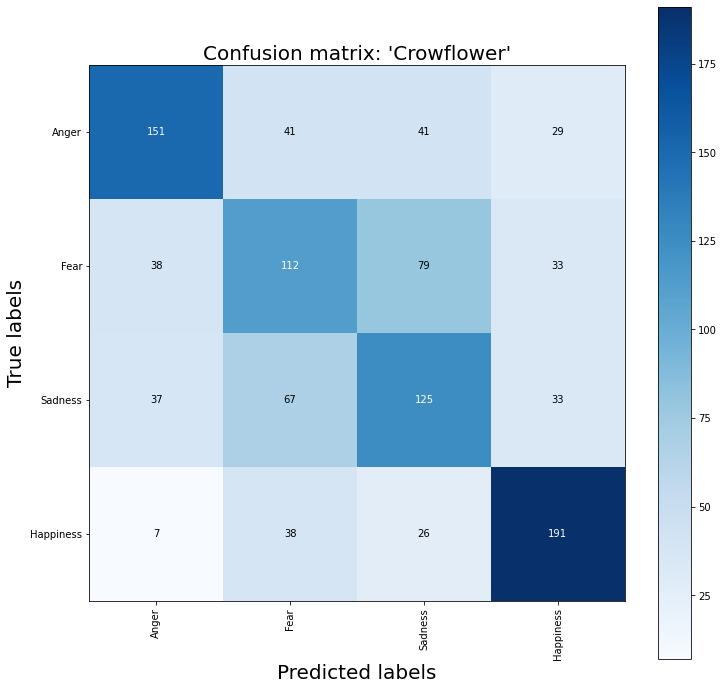

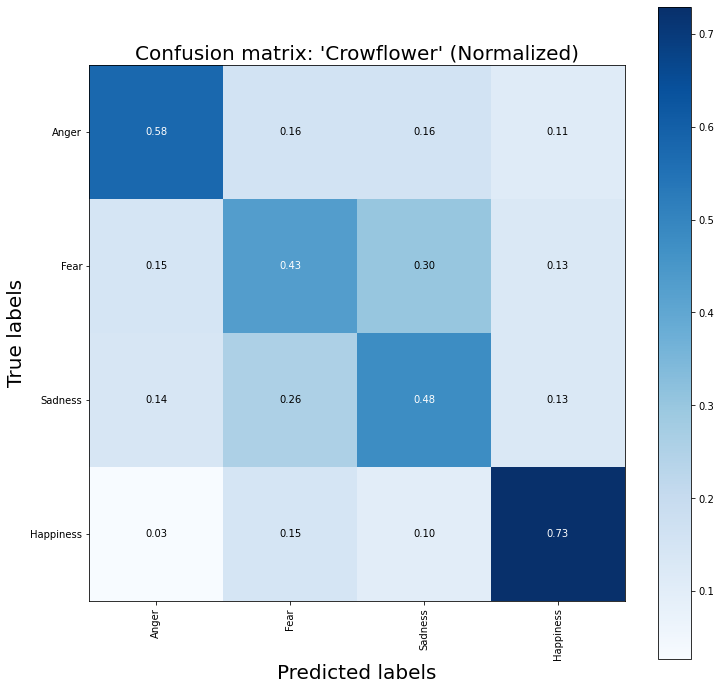

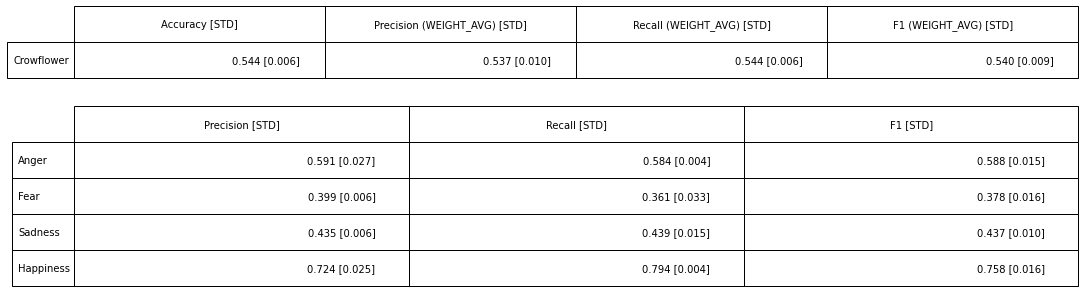

In [ ]:
#evaluate Crowflower dataset using Bert classifier model

train_parameters = {
    "num_epochs": 6,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("Crowflower", model_parameters, train_parameters, load_crowdflower_multiclass)
parameters = ["Crowflower", model_parameters, train_parameters, load_crowdflower_multiclass]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: TEC
TRAINING:
Average loss: 1.144
Average loss: 0.399
Average loss: 0.193
Average loss: 0.103
Average loss: 0.063
POST-TRAINING:
Accuracy: 0.643
EVALUATION REPORT:
Classifier 'TEC':
Accuracy: 0.643
Precision (WEIGHT_AVG): 0.645
Recall (WEIGHT_AVG): 0.643
F1 (WEIGHT_AVG): 0.643
Anger | Precision: 0.648 Recall: 0.623 F1: 0.635 Support: 310
Fear | Precision: 0.670 Recall: 0.648 F1: 0.659 Support: 310
Sadness | Precision: 0.581 Recall: 0.648 F1: 0.613 Support: 310
Happiness | Precision: 0.682 Recall: 0.652 F1: 0.667 Support: 310
CREATING REPORT:
Run: 1
Accuracy: 0.654
Precision (WEIGHT_AVG): 0.657
Recall (WEIGHT_AVG): 0.654
F1 (WEIGHT_AVG): 0.655
Anger | Precision: 0.630 Recall: 0.632 F1: 0.631
Fear | Precision: 0.699 Recall: 0.690 F1: 0.695
Sadness | Precision: 0.574 Recall: 0.623 F1: 0.598
Happiness | Precision: 0.725 Recall: 0.671 F1: 0.697
Run: 2
Accuracy: 0.646
Precision (WEIGHT_AVG): 0.646
Recall (WEIGHT_AVG): 0.646
F1 (WEIGHT_AVG): 0.646
Anger | Precision: 0.639 Recall: 0.652

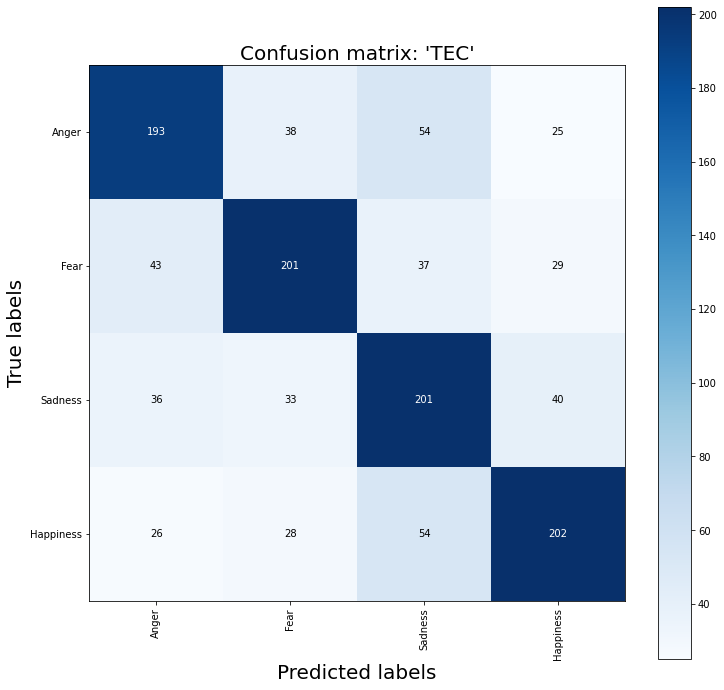

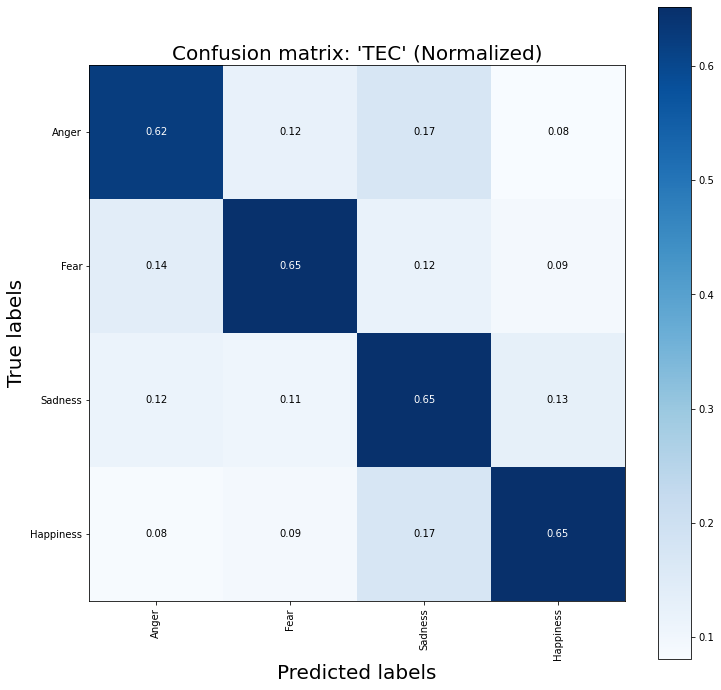

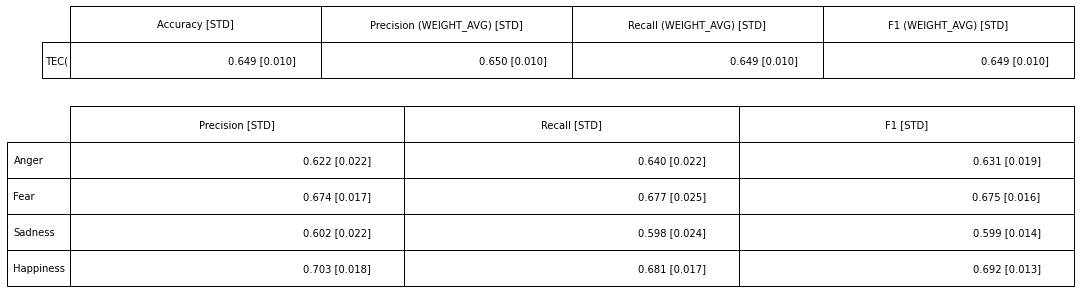

In [ ]:
#evaluate TEC dataset using Bert classifier model
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 32,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("TEC", model_parameters, train_parameters, load_tec_multiclass)
parameters = ["TEC(", model_parameters, train_parameters, load_tec_multiclass]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Wang
TRAINING:
Average loss: 0.997
Average loss: 0.385
Average loss: 0.208
Average loss: 0.127
Average loss: 0.086
POST-TRAINING:
Accuracy: 0.650
EVALUATION REPORT:
Classifier 'Wang':
Accuracy: 0.650
Precision (WEIGHT_AVG): 0.652
Recall (WEIGHT_AVG): 0.650
F1 (WEIGHT_AVG): 0.651
Anger | Precision: 0.685 Recall: 0.663 F1: 0.674 Support: 2000
Fear | Precision: 0.627 Recall: 0.620 F1: 0.623 Support: 2000
Sadness | Precision: 0.580 Recall: 0.615 F1: 0.597 Support: 2000
Happiness | Precision: 0.714 Recall: 0.703 F1: 0.708 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.648
Precision (WEIGHT_AVG): 0.647
Recall (WEIGHT_AVG): 0.648
F1 (WEIGHT_AVG): 0.648
Anger | Precision: 0.644 Recall: 0.656 F1: 0.650
Fear | Precision: 0.643 Recall: 0.623 F1: 0.633
Sadness | Precision: 0.603 Recall: 0.597 F1: 0.600
Happiness | Precision: 0.700 Recall: 0.716 F1: 0.708
Run: 2
Accuracy: 0.652
Precision (WEIGHT_AVG): 0.654
Recall (WEIGHT_AVG): 0.652
F1 (WEIGHT_AVG): 0.652
Anger | Precision: 0.688 Recall:

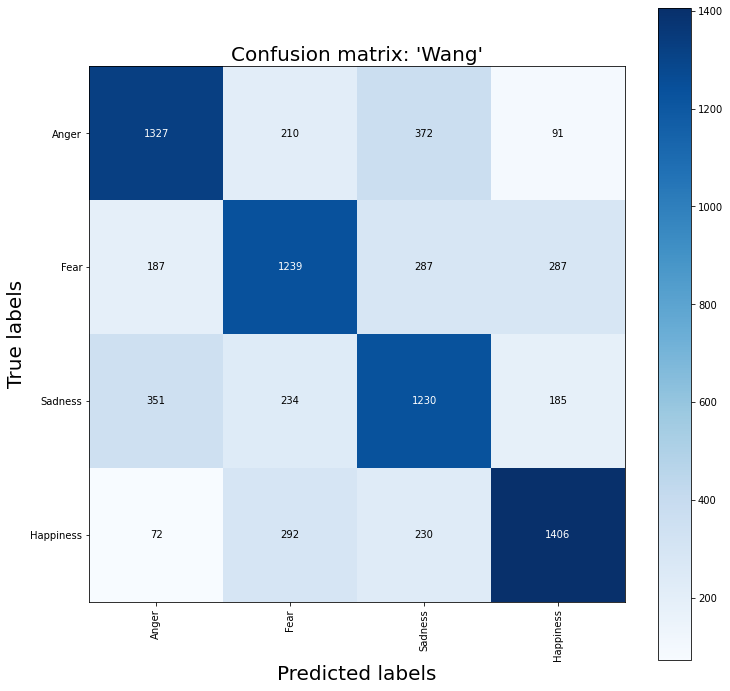

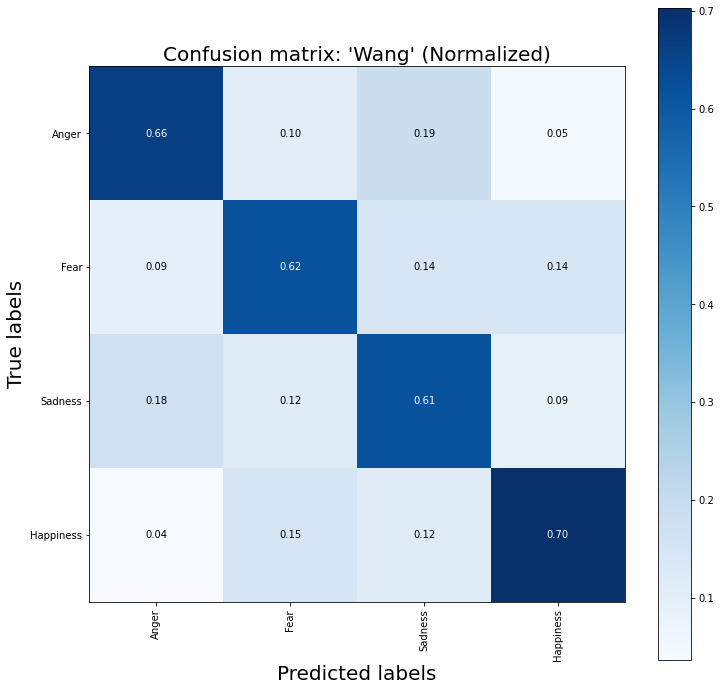

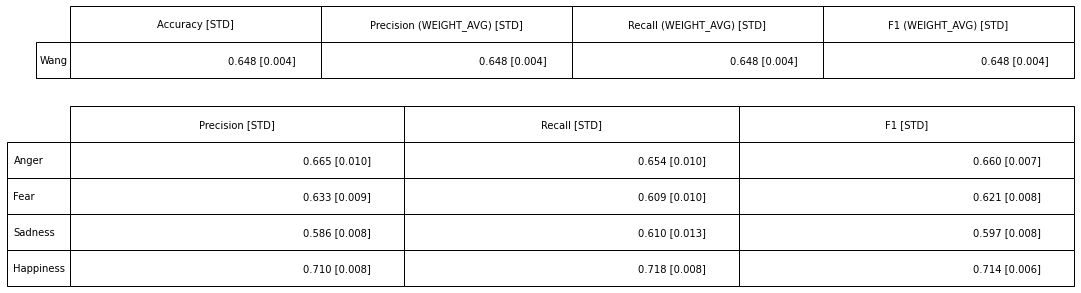

In [ ]:
#Evaluate Wang dataset with 4 emotions using Bert classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("Wang", model_parameters, train_parameters, load_wang_multiclass)
parameters = ["Wang", model_parameters, train_parameters, load_wang_multiclass]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Wang 5
TRAINING:
Average loss: 1.168
Average loss: 0.454
Average loss: 0.247
Average loss: 0.155
Average loss: 0.106
POST-TRAINING:
Accuracy: 0.595
EVALUATION REPORT:
Classifier 'Wang 5':
Accuracy: 0.595
Precision (WEIGHT_AVG): 0.595
Recall (WEIGHT_AVG): 0.595
F1 (WEIGHT_AVG): 0.595
Anger | Precision: 0.644 Recall: 0.629 F1: 0.637 Support: 2000
Fear | Precision: 0.605 Recall: 0.585 F1: 0.595 Support: 2000
Sadness | Precision: 0.532 Recall: 0.561 F1: 0.546 Support: 2000
Happiness | Precision: 0.589 Recall: 0.576 F1: 0.583 Support: 2000
Love | Precision: 0.606 Recall: 0.621 F1: 0.613 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.601
Precision (WEIGHT_AVG): 0.602
Recall (WEIGHT_AVG): 0.601
F1 (WEIGHT_AVG): 0.601
Anger | Precision: 0.641 Recall: 0.650 F1: 0.646
Fear | Precision: 0.620 Recall: 0.599 F1: 0.609
Sadness | Precision: 0.536 Recall: 0.560 F1: 0.548
Happiness | Precision: 0.598 Recall: 0.582 F1: 0.590
Love | Precision: 0.612 Recall: 0.614 F1: 0.613
Run: 2
Accuracy: 0.59

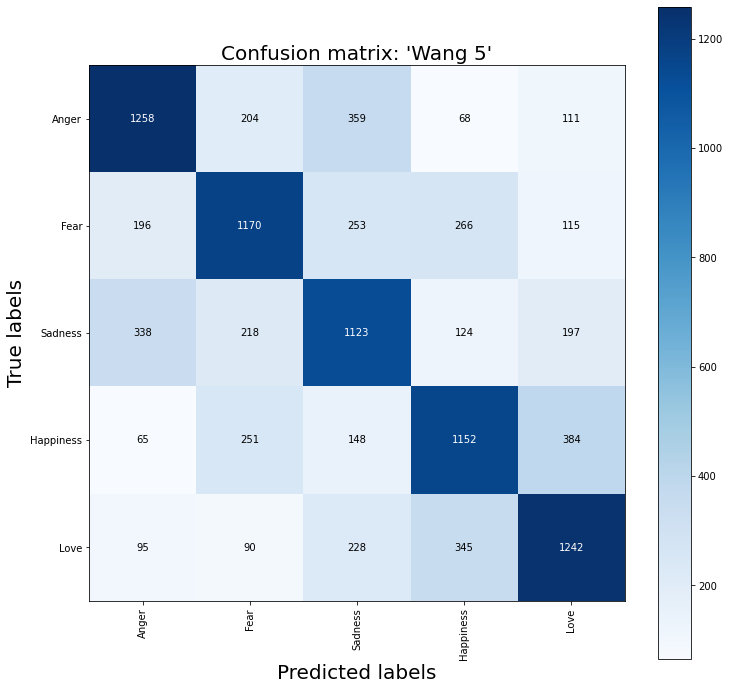

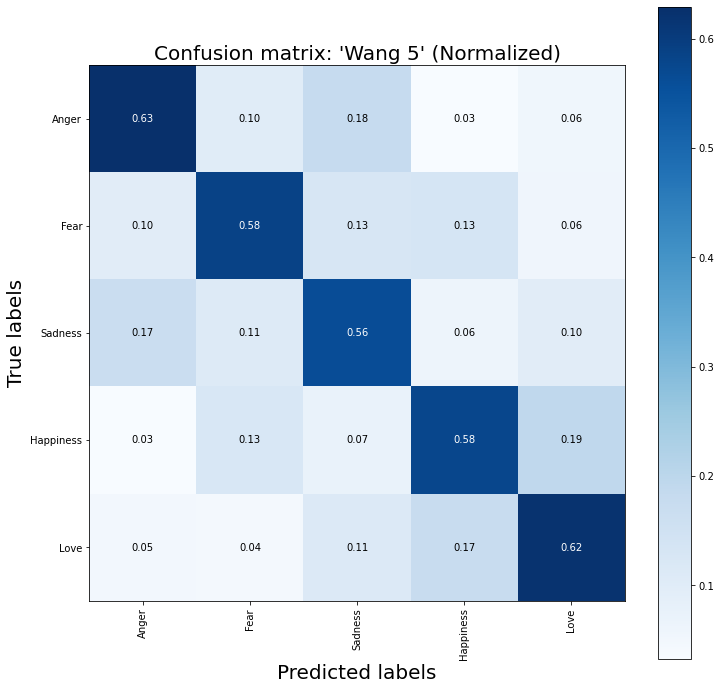

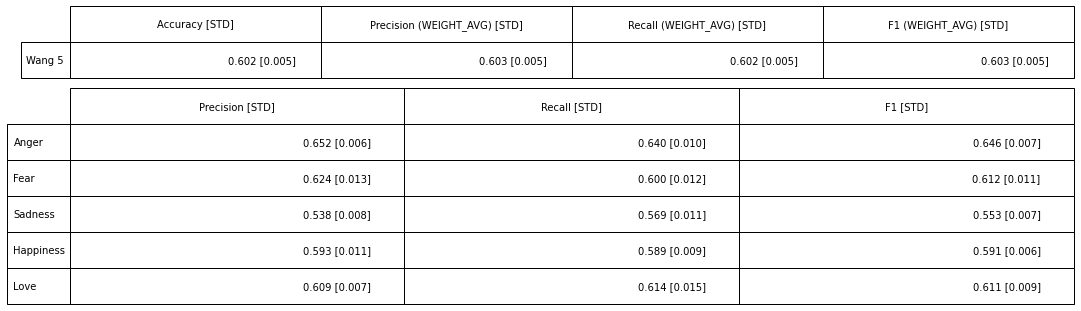

In [ ]:
#Evaluate Wang dataset with 5 emotions using Bert classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 5
}

result = run_multiclass_model("Wang 5", model_parameters, train_parameters, load_wang_multiclass_5)
parameters = ["Wang 5 ", model_parameters, train_parameters, load_wang_multiclass_5]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Wang 6
TRAINING:
Average loss: 1.250
Average loss: 0.493
Average loss: 0.273
Average loss: 0.173
Average loss: 0.121
POST-TRAINING:
Accuracy: 0.593
EVALUATION REPORT:
Classifier 'Wang 6':
Accuracy: 0.593
Precision (WEIGHT_AVG): 0.592
Recall (WEIGHT_AVG): 0.593
F1 (WEIGHT_AVG): 0.592
Anger | Precision: 0.630 Recall: 0.646 F1: 0.638 Support: 2000
Fear | Precision: 0.593 Recall: 0.604 F1: 0.598 Support: 2000
Sadness | Precision: 0.537 Recall: 0.538 F1: 0.537 Support: 2000
Happiness | Precision: 0.519 Recall: 0.527 F1: 0.523 Support: 2000
Love | Precision: 0.578 Recall: 0.515 F1: 0.545 Support: 2000
Thankfulness | Precision: 0.695 Recall: 0.729 F1: 0.711 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.598
Precision (WEIGHT_AVG): 0.598
Recall (WEIGHT_AVG): 0.598
F1 (WEIGHT_AVG): 0.598
Anger | Precision: 0.668 Recall: 0.636 F1: 0.652
Fear | Precision: 0.604 Recall: 0.613 F1: 0.609
Sadness | Precision: 0.527 Recall: 0.574 F1: 0.549
Happiness | Precision: 0.547 Recall: 0.535 F1: 0.541

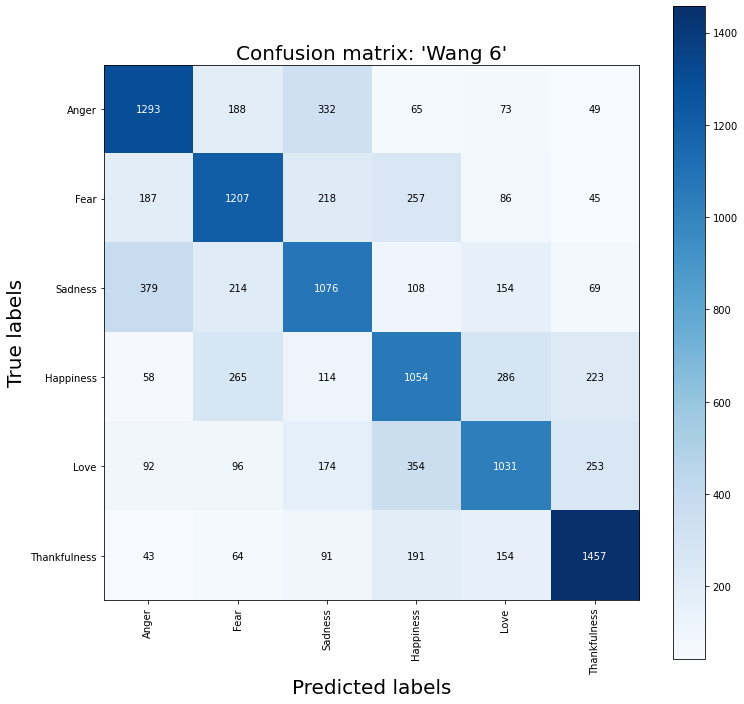

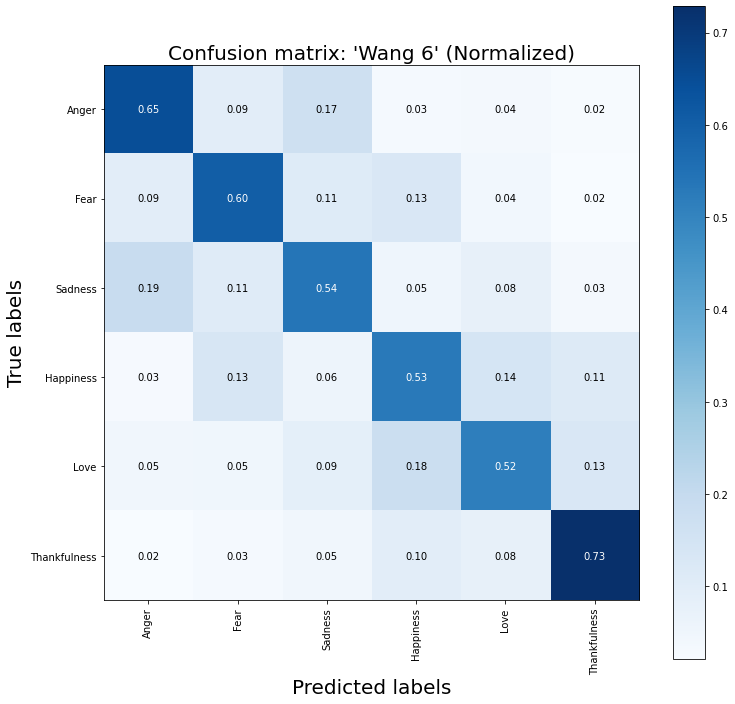

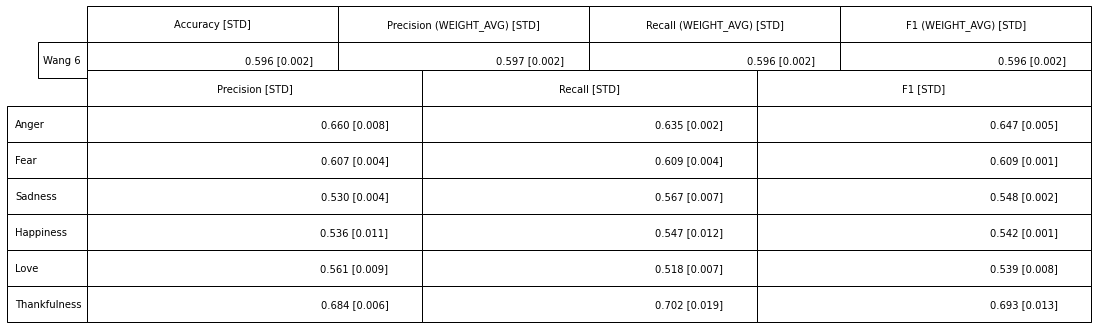

In [ ]:
#Evaluate Wang dataset with 6 emotions using Bert classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 6
}

result = run_multiclass_model("Wang 6", model_parameters, train_parameters, load_wang_multiclass_6)
parameters = ["Wang 6 ", model_parameters, train_parameters, load_wang_multiclass_6]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: vent4
TRAINING:
Average loss: 1.042
Average loss: 0.411
Average loss: 0.250
Average loss: 0.174
Average loss: 0.132
POST-TRAINING:
Accuracy: 0.677
EVALUATION REPORT:
Classifier 'vent4':
Accuracy: 0.677
Precision (WEIGHT_AVG): 0.678
Recall (WEIGHT_AVG): 0.677
F1 (WEIGHT_AVG): 0.677
anger | Precision: 0.662 Recall: 0.669 F1: 0.666 Support: 2000
fear | Precision: 0.629 Recall: 0.596 F1: 0.612 Support: 2000
sadness | Precision: 0.608 Recall: 0.640 F1: 0.624 Support: 2000
happiness | Precision: 0.813 Recall: 0.804 F1: 0.808 Support: 2000
CREATING REPORT:
Run: 1


Token indices sequence length is longer than the specified maximum sequence length for this model (901 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.672
Precision (WEIGHT_AVG): 0.674
Recall (WEIGHT_AVG): 0.672
F1 (WEIGHT_AVG): 0.672
anger | Precision: 0.642 Recall: 0.664 F1: 0.653
fear | Precision: 0.661 Recall: 0.597 F1: 0.627
sadness | Precision: 0.577 Recall: 0.622 F1: 0.599
happiness | Precision: 0.817 Recall: 0.803 F1: 0.810
Run: 2
Accuracy: 0.675
Precision (WEIGHT_AVG): 0.678
Recall (WEIGHT_AVG): 0.675
F1 (WEIGHT_AVG): 0.676
anger | Precision: 0.659 Recall: 0.669 F1: 0.664
fear | Precision: 0.652 Recall: 0.601 F1: 0.625
sadness | Precision: 0.581 Recall: 0.633 F1: 0.606
happiness | Precision: 0.819 Recall: 0.797 F1: 0.808
Run: 3
Accuracy: 0.672
Precision (WEIGHT_AVG): 0.677
Recall (WEIGHT_AVG): 0.672
F1 (WEIGHT_AVG): 0.673
anger | Precision: 0.645 Recall: 0.664 F1: 0.655
fear | Precision: 0.678 Recall: 0.581 F1: 0.626
sadness | Precision: 0.574 Recall: 0.654 F1: 0.612
happiness | Precision: 0.811 Recall: 0.790 F1: 0.800
Run: 4
Accuracy: 0.678
Precision (WEIGHT_AVG): 0.683
Recall (WEIGHT_AVG): 0.678
F1 (WEIGHT_AVG)

Token indices sequence length is longer than the specified maximum sequence length for this model (1672 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.677
Precision (WEIGHT_AVG): 0.678
Recall (WEIGHT_AVG): 0.677
F1 (WEIGHT_AVG): 0.677
anger | Precision: 0.662 Recall: 0.659 F1: 0.661
fear | Precision: 0.655 Recall: 0.600 F1: 0.626
sadness | Precision: 0.588 Recall: 0.638 F1: 0.612
happiness | Precision: 0.809 Recall: 0.811 F1: 0.810


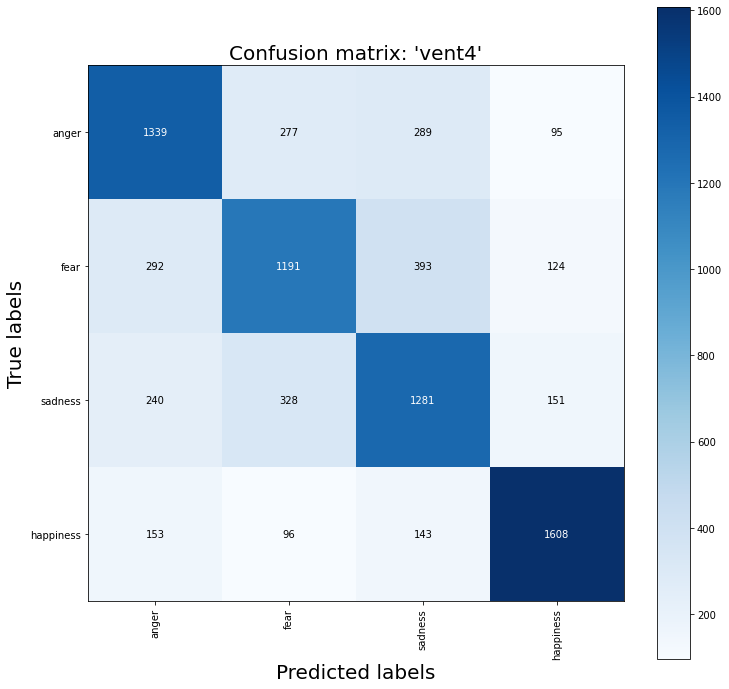

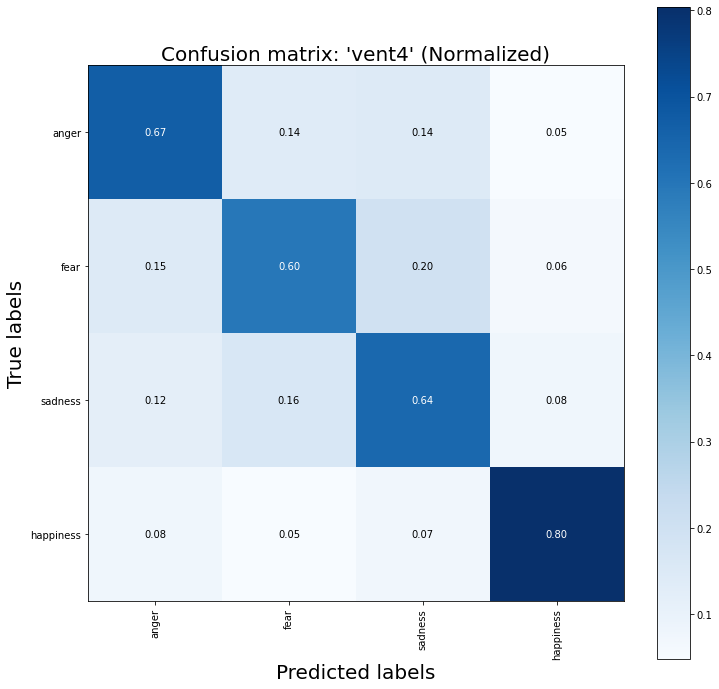

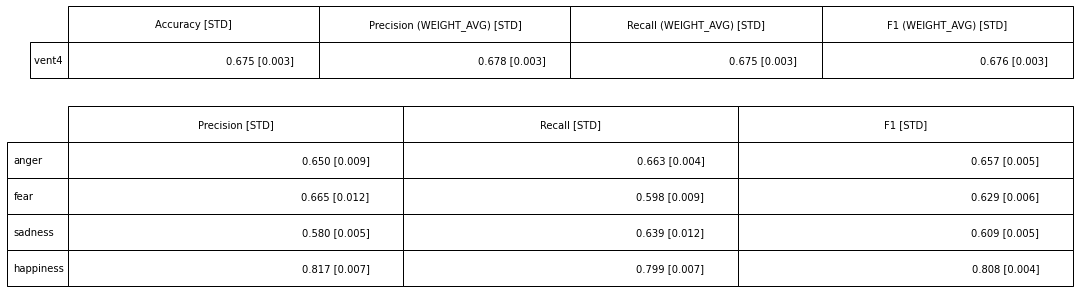

In [ ]:
#Evaluate Vent dataset with 4 emotions using Bert classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 256,
    "num_timesteps": 35,
    "num_classes": 4
}
#The dataset is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent 4", model_parameters, train_parameters, load_vent_multiclass_4)
parameters = ["Vent 4", model_parameters, train_parameters, load_vent_multiclass_4]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


Cloning into 'new_dat'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.
Checking out files: 100% (4/4), done.



MODEL: Vent 5
TRAINING:
Average loss: 1.237
Average loss: 0.499
Average loss: 0.303
Average loss: 0.212
Average loss: 0.161
POST-TRAINING:
Accuracy: 0.618
EVALUATION REPORT:
Classifier 'Vent 5':
Accuracy: 0.618
Precision (WEIGHT_AVG): 0.621
Recall (WEIGHT_AVG): 0.618
F1 (WEIGHT_AVG): 0.618
anger | Precision: 0.617 Recall: 0.653 F1: 0.635 Support: 2000
fear | Precision: 0.593 Recall: 0.597 F1: 0.595 Support: 2000
sadness | Precision: 0.535 Recall: 0.589 F1: 0.561 Support: 2000
happiness | Precision: 0.680 Recall: 0.677 F1: 0.678 Support: 2000
love | Precision: 0.680 Recall: 0.572 F1: 0.621 Support: 2000
CREATING REPORT:
Run: 1


Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.621
Precision (WEIGHT_AVG): 0.622
Recall (WEIGHT_AVG): 0.621
F1 (WEIGHT_AVG): 0.620
anger | Precision: 0.627 Recall: 0.663 F1: 0.645
fear | Precision: 0.613 Recall: 0.603 F1: 0.608
sadness | Precision: 0.555 Recall: 0.595 F1: 0.574
happiness | Precision: 0.667 Recall: 0.701 F1: 0.684
love | Precision: 0.650 Recall: 0.544 F1: 0.592
Run: 2


Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.625
Precision (WEIGHT_AVG): 0.627
Recall (WEIGHT_AVG): 0.625
F1 (WEIGHT_AVG): 0.625
anger | Precision: 0.627 Recall: 0.664 F1: 0.645
fear | Precision: 0.624 Recall: 0.597 F1: 0.610
sadness | Precision: 0.550 Recall: 0.621 F1: 0.583
happiness | Precision: 0.679 Recall: 0.683 F1: 0.681
love | Precision: 0.658 Recall: 0.559 F1: 0.605


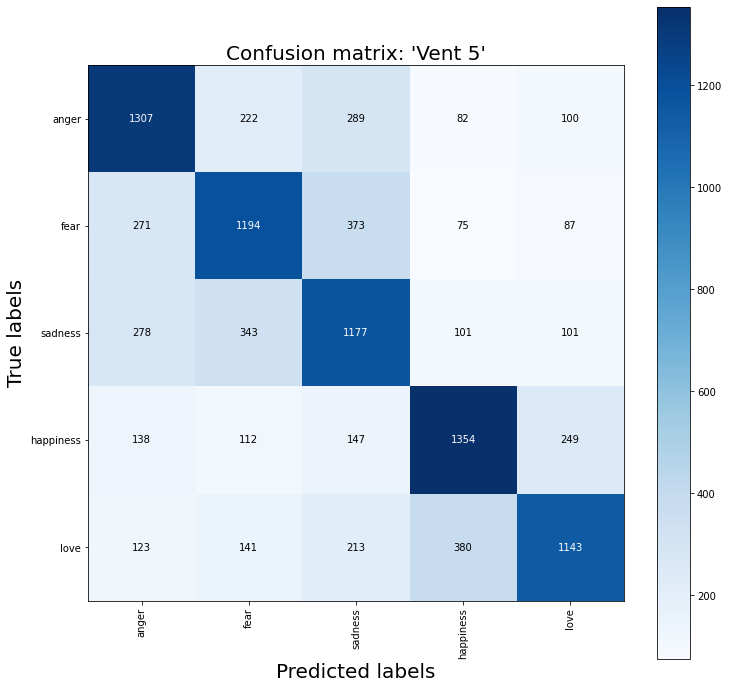

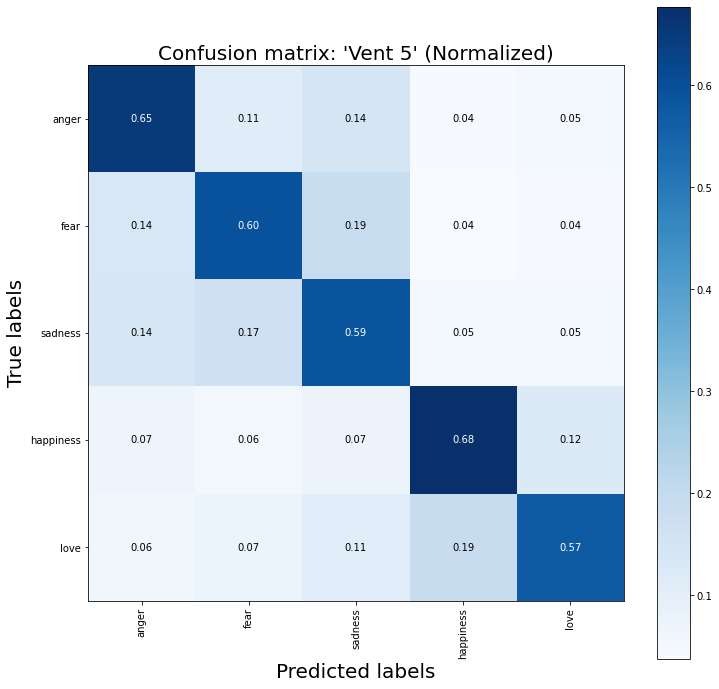

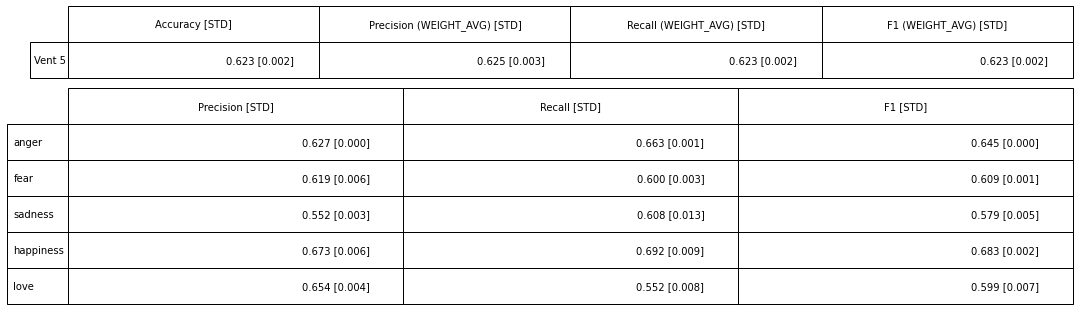

In [12]:
#Evaluate Vent dataset with 5 emotions using Bert classifier model
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 256,
    "num_timesteps": 35,
    "num_classes": 5
}
#The dataset is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent 5", model_parameters, train_parameters, load_vent_multiclass_5)
parameters = ["Vent 5", model_parameters, train_parameters, load_vent_multiclass_5]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: Vent 6
TRAINING:
Average loss: 1.630
Average loss: 0.675
Average loss: 0.397
Average loss: 0.279
Average loss: 0.213
POST-TRAINING:
Accuracy: 0.530
EVALUATION REPORT:
Classifier 'Vent 6':
Accuracy: 0.530
Precision (WEIGHT_AVG): 0.532
Recall (WEIGHT_AVG): 0.530
F1 (WEIGHT_AVG): 0.529
Anger | Precision: 0.541 Recall: 0.592 F1: 0.565 Support: 600
Fear | Precision: 0.571 Recall: 0.558 F1: 0.564 Support: 600
Sadness | Precision: 0.487 Recall: 0.528 F1: 0.507 Support: 600
Happiness | Precision: 0.491 Recall: 0.553 F1: 0.520 Support: 600
Love | Precision: 0.506 Recall: 0.423 F1: 0.461 Support: 600
Thankfulness | Precision: 0.595 Recall: 0.523 F1: 0.557 Support: 600
CREATING REPORT:
Run: 1


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.545
Precision (WEIGHT_AVG): 0.547
Recall (WEIGHT_AVG): 0.545
F1 (WEIGHT_AVG): 0.543
Anger | Precision: 0.569 Recall: 0.630 F1: 0.598
Fear | Precision: 0.582 Recall: 0.562 F1: 0.572
Sadness | Precision: 0.521 Recall: 0.590 F1: 0.553
Happiness | Precision: 0.487 Recall: 0.545 F1: 0.514
Love | Precision: 0.520 Recall: 0.425 F1: 0.468
Thankfulness | Precision: 0.602 Recall: 0.517 F1: 0.556
Run: 2
Accuracy: 0.557
Precision (WEIGHT_AVG): 0.559
Recall (WEIGHT_AVG): 0.557
F1 (WEIGHT_AVG): 0.557
Anger | Precision: 0.622 Recall: 0.628 F1: 0.625
Fear | Precision: 0.581 Recall: 0.552 F1: 0.566
Sadness | Precision: 0.515 Recall: 0.580 F1: 0.545
Happiness | Precision: 0.515 Recall: 0.583 F1: 0.547
Love | Precision: 0.514 Recall: 0.470 F1: 0.491
Thankfulness | Precision: 0.609 Recall: 0.527 F1: 0.565


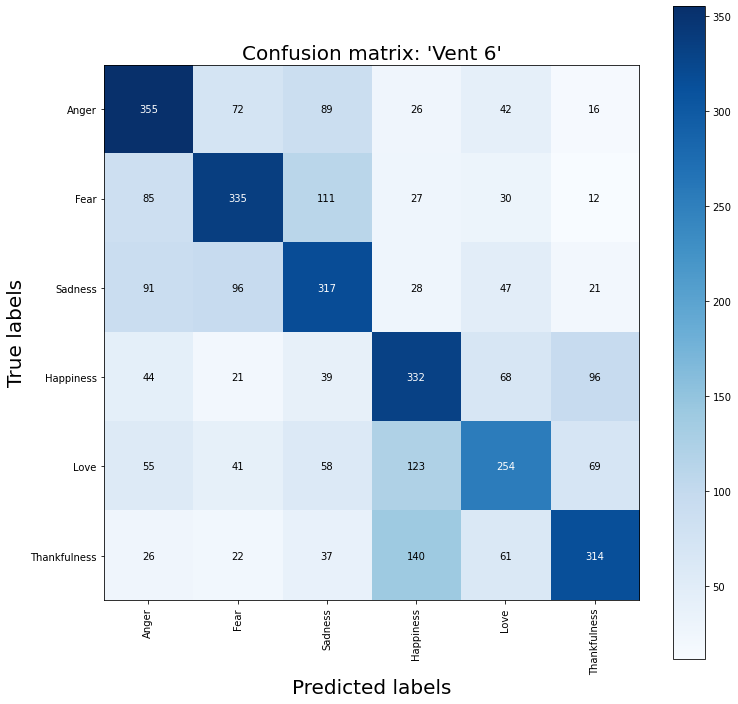

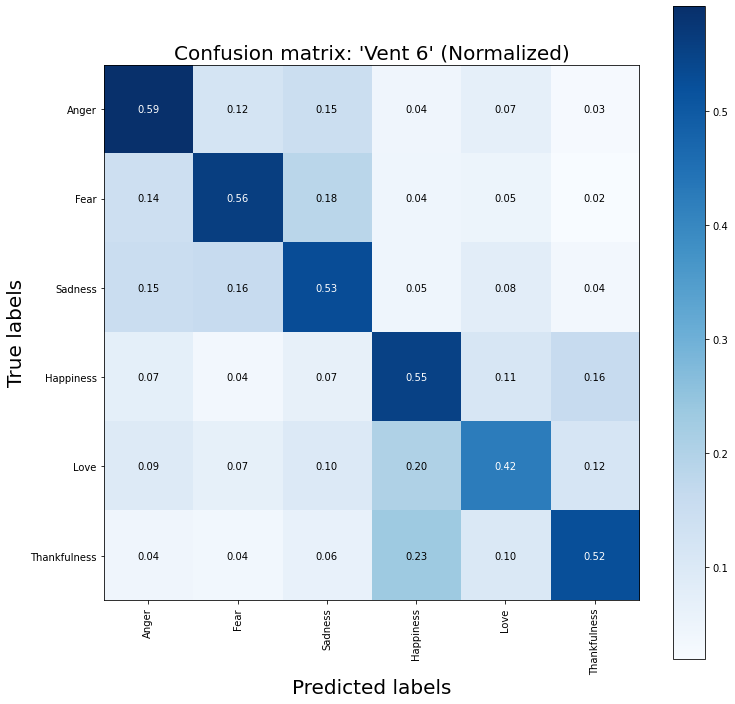

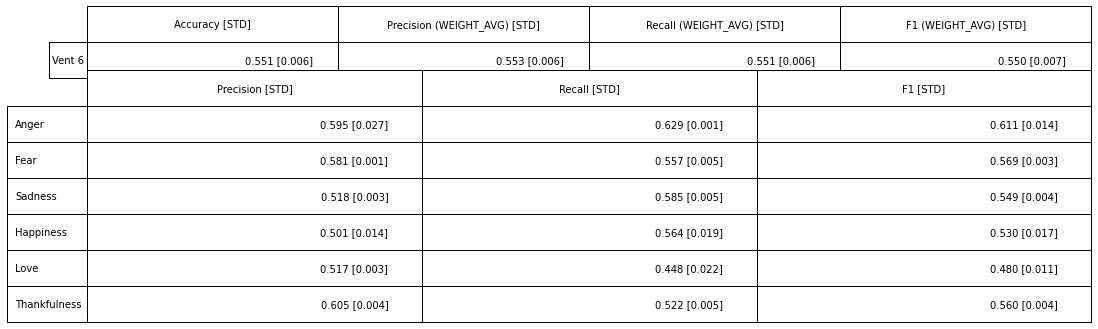

In [16]:
#Evaluate Vent dataset with 6 emotions using Bert classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 256,
    "num_timesteps": 35,
    "num_classes": 6
}
#The dataset is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent 6", model_parameters, train_parameters, load_vent_multiclass_6)
parameters = ["Vent 6", model_parameters, train_parameters, load_vent_multiclass_6]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)
